In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import itertools
import random
from src.encoders_decoders import *
from src.losses import *
from src.useful_functions import *
from torch.utils.data import DataLoader


SyntaxError: invalid syntax (encoders_decoders.py, line 51)

In [2]:
def hparameters_dict(N_EPOCHS=500,N_SAMPLES=10000,BATCH_SIZE=100,lr=1e-4):
    hp = { "N_EPOCHS":N_EPOCHS, 
            "N_SAMPLES":N_SAMPLES,
            "BATCH_SIZE":BATCH_SIZE,
            "lr":lr,
        }
    return hp

In [3]:
def f(a,**kwargs):
    hp = hparameters(**kwargs)
    print(N)

In [4]:
def train(encoder,decoder,q,p_x,**kwargs):
    hp = hparameters(**kwargs)
    x_samples = p_x.sample((N_SAMPLES,))[:,None]
    x_sorted,indices = x_samples.sort(dim=0)
    x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
    x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
    return

Text(0, 0.5, 'Encoding')

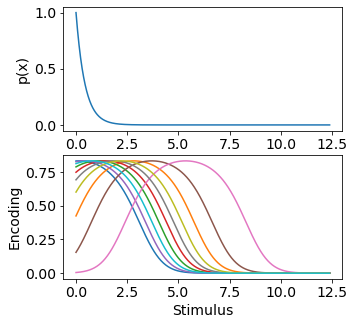

In [100]:
#Architecture parameters and distributions of stimuli
N = 10
K = 5
M = 100
w = torch.distributions.Categorical(torch.tensor([0.4,0.6]))
gs = torch.distributions.normal.Normal(torch.Tensor([-4,4]),torch.tensor([1,2]))
p_x = torch.distributions.mixture_same_family.MixtureSameFamily(w,gs)
p_x = torch.distributions..Exponential(1)
#Training parameters.
#PRE_EPOCHS = 100
N_EPOCHS = 500
N_SAMPLES = 10000
lr = 1e-4
BATCH_SIZE = 100
#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_test = p_x.sample((N_SAMPLES,))[:,None]
x_tsorted,_ = x_test.sort(dim=0)
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]
#Initialize model parameters
enc = BernoulliEncoder(N,x_min-1,x_max+1,x_sorted)
#enc.cs = torch.nn.Parameter(torch.Tensor(np.linspace(x_min,x_max,num=N))[None,:])
enc.As = torch.nn.Parameter(5*torch.ones(N)[None,:])
#enc.log_sigmas = torch.nn.Parameter(torch.log(torch.ones(N)*(x_max-x_min)/(2*N))[None,:])
q = rate_ising(N)
#q = rate_vampBernoulli(K,x_fine)
#x_k = x_fine[random.sample(range(1000),K)]
#q.x_k = torch.nn.Parameter(x_k)
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
dec = MLPDecoder2n(N,M)
fig,axs = plt.subplots(2,1,figsize=(5,5))
axs[0].plot(x_fine,10**p_x.log_prob(x_fine).detach())
axs[0].set_xlabel("Stimulus")
axs[0].set_ylabel("p(x)")
#enc.As = torch.nn.Parameter(torch.ones(N)[None,:])
axs[1].plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
axs[1].set_xlabel("Stimulus")
axs[1].set_ylabel("Encoding")
#axs2 = axs.twinx()


In [101]:
params =   list(enc.parameters()) + list(dec.parameters())  + list(q.parameters())
#params = q.parameters()
#lr = 1e-4
lVec,dVec,rVec,bVec = ([] for _ in range(4))
opt = torch.optim.Adam(params,lr)
#Scheduled Beta
bVec = [2*i/N_EPOCHS  if 2*i/N_EPOCHS<1 else 1 for i in range(N_EPOCHS)]
#bVec = [1/(1 + np.exp(-x/30 + 7)) for x in range(N_EPOCHS)]
for e in range(N_EPOCHS):
    lav = dav = rav = 0
    beta = bVec[e]
    #beta=1
    for x_ in x_data:
        rate = q(enc,x_)
        #distortion = distortion_gaussian(x_,enc,dec,lat_samp = 50,tau=0.01)
        distortion = distortion_analytical(x_,enc,dec,q.r_all)
        #print(enc.log_sigmas.grad)
        loss =  distortion +beta*rate
        opt.zero_grad()
        loss.backward()
        opt.step()
        lav += distortion + rate
        dav += distortion
        rav += rate
    lVec.append(lav.item()/len(x_data))
    rVec.append(rav.item()/len(x_data))
    dVec.append(dav.item()/len(x_data))
    #bVec.append(beta)
    print(f"Epoch: {e} || ELBO: {lVec[-1]}")


Epoch: 0 || ELBO: 5.886663818359375
Epoch: 1 || ELBO: 5.382421264648437
Epoch: 2 || ELBO: 4.713402404785156
Epoch: 3 || ELBO: 4.103943481445312
Epoch: 4 || ELBO: 3.5779714965820313
Epoch: 5 || ELBO: 3.14322998046875
Epoch: 6 || ELBO: 2.7932275390625
Epoch: 7 || ELBO: 2.5106944274902343
Epoch: 8 || ELBO: 2.2808187866210936
Epoch: 9 || ELBO: 2.095609436035156
Epoch: 10 || ELBO: 1.9497891235351563
Epoch: 11 || ELBO: 1.8370367431640624
Epoch: 12 || ELBO: 1.7502064514160156
Epoch: 13 || ELBO: 1.6828077697753907
Epoch: 14 || ELBO: 1.6297927856445313
Epoch: 15 || ELBO: 1.5877572631835937
Epoch: 16 || ELBO: 1.5539573669433593
Epoch: 17 || ELBO: 1.5263040161132813
Epoch: 18 || ELBO: 1.503362579345703
Epoch: 19 || ELBO: 1.4838475036621093
Epoch: 20 || ELBO: 1.4669071960449218
Epoch: 21 || ELBO: 1.4518551635742187
Epoch: 22 || ELBO: 1.4381228637695314
Epoch: 23 || ELBO: 1.4253587341308593
Epoch: 24 || ELBO: 1.4131834411621094
Epoch: 25 || ELBO: 1.4012875366210937
Epoch: 26 || ELBO: 1.389577789306

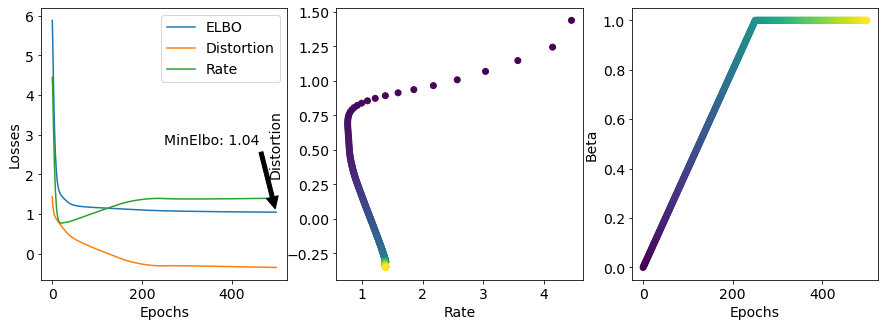

In [102]:
fig,ax = training_plots(lVec,dVec,rVec,bVec)
#fig.savefig("beta1_training.pdf")

In [103]:
min(dVec)

-0.3512689208984375

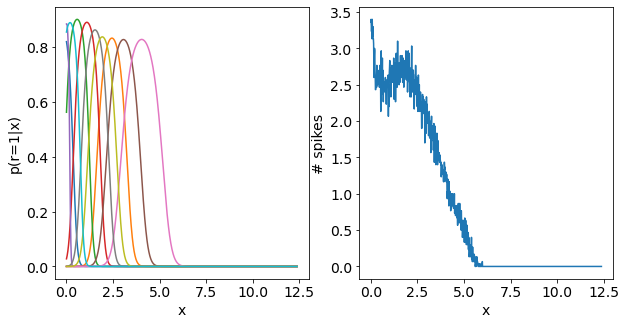

In [104]:
fig,axs = encoder_plots(enc,x_fine)
#fig.savefig("beta1_encoder.pdf")

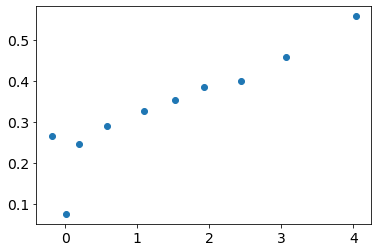

In [105]:
with torch.no_grad():
    plt.scatter(enc.cs, torch.exp(enc.log_sigmas))

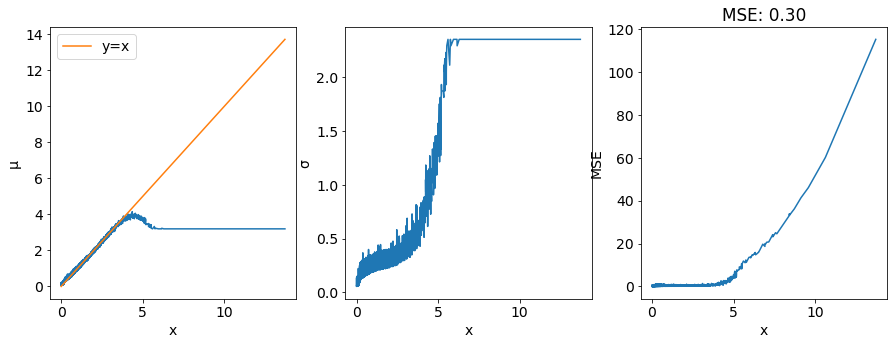

In [106]:
fig,axs = decoder_plots(enc,dec,x_tsorted)
#fig.savefig("beta1_decoder.pdf")

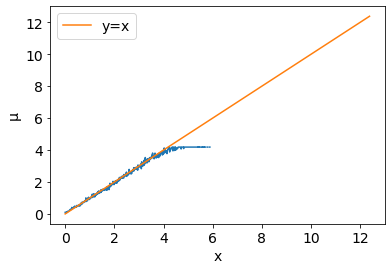

In [107]:
with torch.no_grad():
    r = enc.sample(x_fine,15)
    mu_dec,log_sigma_dec = dec(r)
    mu_dec = torch.where((r.sum(dim=2)) >0,mu_dec.double(),float('nan'))
    x_ext = dec.sample(r,10)
    mseVec = ((x_ext - x_fine[None,:])**2).mean(dim=(0,2))
    fig,axs = plt.subplots()
    axs.plot(x_fine,mu_dec.nanmean(dim=1))
    axs.plot(x_fine,x_fine,label="y=x")
    axs.legend()
    axs.set_xlabel('x')
    axs.set_ylabel('μ')


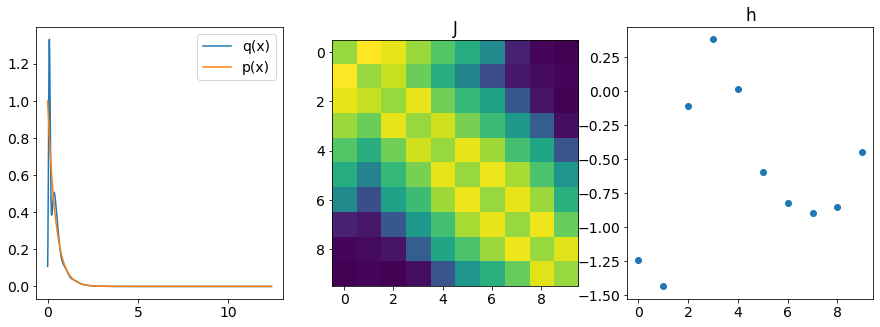

In [108]:
_,indices = enc.cs.sort(dim=1)
indices = torch.squeeze(indices)
fig,axs = generative_model_analytical_plots(q,dec,p_x,x_fine,indices)
#fig.savefig("beta1_gm.pdf")

In [96]:
h =torch.histogram(x_samples)

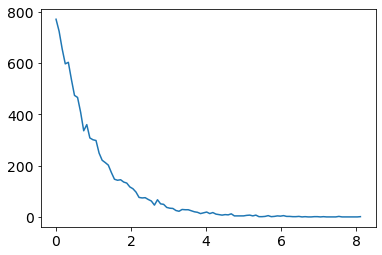

In [97]:
plt.plot(h.bin_edges[0:-1],h.hist)